# Worst Place To Work (BR) 

Durante o mês de março de 2024, um usuário do Linkedin soltou uma enquete anônima com texto livre pra reclamar do lugar que você trabalha. Todas as entradas nesse dataset, que é uma planilha com quase 2k avaliações nesse momento (26/03/2024). [ref]

[ref]: https://docs.google.com/spreadsheets/d/1u1_8ND_BY1DaGaQdu0ZRZPebrOaTJekE9hyw_7BAlzw/htmlview?usp=sharing

A proposta desse notebook é realizar uma avaliação usando conceitos de Processamento de Linguagem Natural (NLP) para quantificar propriedades dessas avaliações, entre elas:

- Limpeza de dados não-estruturados
- Normalização de entidade nomeada (empresa) usando algoritmo greedy
- Nuvem de palavras com ngrams (busca de tópicos comuns)
- Aprendizagem não-supervisionada com representação visual de proximidade de empresas baseado em feedbacks negativos (t-SNE over tfidf/word2vec)

# Carregar dataset

In [1]:
import datetime
import pandas as pd

In [2]:
from nlp_tir import datasets

df = datasets.get_dataset_br_worst_places_to_work()
df = df.rename(
    columns={
        "Carimbo de data/hora": "timestamp",
        "Nome da empresa": "company",
        "Motivos": "reasons"
    }
)
print(df.iloc[:2, 0])
df = df.drop(0).drop(df.columns[0], axis=1) # drop row/column identification
df

0    ANDERSON WEBER - LINKEDIN: https://www.linkedi...
1    Mande sua denúncia aqui: https://worstplacetow...
Name: CRIADO POR ANDERSON WEBER: www.instagram.com/apenasweber, dtype: object


,timestamp,company,reasons
1,27/03/2024 11:36:24,99,"Empresa que paga de ""cool"" mas acoberta direto..."
2,27/03/2024 11:41:43,99,Péssima empresa para trabalhar!! Líderes de MK...
3,27/03/2024 12:06:45,99,"Racistas, machistas, gordofóbicos, transfóbico..."
4,27/03/2024 12:07:41,99,Fui demitida da noite pro dia com a cara de pa...
5,27/03/2024 12:08:48,99,Completamente delulus e absurdamente fora da r...
...,...,...,...
5344,27/03/2024 20:45:30,EQUINIX,"Sofri assédio moral, e quando foi reportado ao..."
5345,27/03/2024 20:45:35,Rede D’or,"Salário baixo, chefia que acha que é dona da r..."
5346,27/03/2024 20:45:49,Refrigás,Quer atribuir funções fora do cargo e achar qu...
5347,27/03/2024 20:45:53,Alelo,Lideres totalmente abusivos. Área de TI e Prod...


In [3]:
# Fix type df.timestamp column to be a datetime
df["timestamp"] = df.timestamp.apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M:%S"))

In [4]:
df.describe()

,timestamp
count,5348
mean,2024-03-25 15:23:34.636686592
min,2024-03-18 08:39:30
25%,2024-03-25 17:42:53.249999872
50%,2024-03-27 10:23:19.500000
75%,2024-03-27 15:25:50.500000
max,2024-03-27 20:46:00


# Normalização de dados

## Remover ruído

Definição de ruído nesse caso: pessoas que só queriam visualizar ou deram razões pouco significativas pra continuar na análise. Estimei uma eurística com duas regras:

1. O campo empresa e motivos foram preenchidos com o mesmo conteúdo;
2. O campo motivos tem menos de 6 caracteres.

In [5]:

noise_query = (df.company.str.lower() == df.reasons.str.lower()) | (df.reasons.str.len() <= 6) 
df_noise = df[noise_query]
display(df_noise)
print("Registros a serem removidos: ", len(df_noise))

,timestamp,company,reasons
21,2024-03-27 20:31:35,<script>alert('j0ds0on')</script>,<script>alert('j0ds0on')</script>
47,2024-03-27 17:35:44,A,A
212,2024-03-27 13:23:02,AJ SOLUTIONS,NENHUM
407,2024-03-27 17:12:47,AQUARIANO,NATO
441,2024-03-26 23:16:17,asdaasa,das
515,2024-03-27 18:25:02,Autônomo,Autônomo
587,2024-03-27 18:45:26,Balantec,Gestão
746,2024-03-18 22:09:55,Bla,Ble
1245,2024-03-27 19:54:32,Confidencial,Confidencial
1342,2024-03-27 12:33:44,D,SD


Registros a serem removidos:  46


In [6]:
df = df[~noise_query].dropna()

## Normalizar empresas

- Colocar tudo em caixa baixa e remover pontuação
- Aplicar normalização de entidade usando tradução via aliases (hand-written rule)

In [7]:
import string

translation_punctuation = str.maketrans({c: " " for c in string.punctuation})

In [8]:
from collections import Counter
from sklearn.feature_extraction.text import strip_accents_ascii
# after lower + strip + remove dots
aliases_map = {
    # normalized -> aliases
    "xp": ["xp investimentos", "xp inc"],
    "btg pactual": ["btg"],
    "itau": ["itau unibanco"],
    "localiza co": ["localizaco"],
    "compass uol": ["compasso uol", "compassuol"],
    "f1rst empresa do santander": ['f1rst digital services', 'f1rst tecnologia banco santander', 'f1rst tecnologia santander', 'f1rst santander', 'f1rst'],
    "vivo": ["vivo telefonica brasil"]
}

def text_series_normalizer(series: pd.Series):
    return (
        series
        .str.translate(translation_punctuation)
        .str.lower()
        .str.strip()
        .replace(regex=r"\s+", value=" ")  # remove duplicated space
        .apply(lambda c: strip_accents_ascii(c) if isinstance(c, str) else c)
        .apply(lambda c: translate_map.get(c, c))
)

translate_map = {
    alias: normalized_term
    for normalized_term, aliases in aliases_map.items()
    for alias in aliases
}

company_normalized = text_series_normalizer(df.company)

In [9]:
df.company = company_normalized

## Normalizar motivos

- Aplicar mesmas regras de normalização de texto anterior, sem a normalização de entidade
- Agrupar motivos pelas mesmas empresas

In [10]:
df.reasons = text_series_normalizer(df.reasons)
df

,timestamp,company,reasons
1,2024-03-27 11:36:24,99,empresa que paga de cool mas acoberta diretor ...
2,2024-03-27 11:41:43,99,pessima empresa para trabalhar lideres de mkt ...
3,2024-03-27 12:06:45,99,racistas machistas gordofobicos transfobicos u...
4,2024-03-27 12:07:41,99,fui demitida da noite pro dia com a cara de pa...
5,2024-03-27 12:08:48,99,completamente delulus e absurdamente fora da r...
...,...,...,...
5344,2024-03-27 20:45:30,equinix,sofri assedio moral e quando foi reportado ao ...
5345,2024-03-27 20:45:35,rede dor,salario baixo chefia que acha que e dona da re...
5346,2024-03-27 20:45:49,refrigas,quer atribuir funcoes fora do cargo e achar qu...
5347,2024-03-27 20:45:53,alelo,lideres totalmente abusivos area de ti e produ...


In [11]:
df_agg = (
    df.groupby(["company"], as_index = False)
      .agg(reasons=("reasons", ' '.join), count=("company", "count"))
      .sort_values(by="count", ascending=False)
)
with pd.option_context('display.max_colwidth', 200,
                       'display.max_columns', None,
                       'display.max_rows', None):
    display(df_agg.head(50))

,company,reasons,count
2642,wise system,o dono dessa empresa se comporta como um ditador uma empresa de software onde tem 2 devs o dono e um jr nao entregam o que prometem para os clientes quando tem problemas no sistema o proprio supor...,110
2562,vhsys,empresa nada recomendavel para se trabalhar pessimo ambiente diretores parecendo o patati e o patata nao sabem o que querem e acabam demitindo e culpando pessoas que nao tem nada a ver com a incom...,59
1369,itau,desorganizacao e hierarquia cultura falsa e extremamente toxica fazem uma propaganda linda falam que valorizam pessoas mas demitem aos montes por eficiencia enquanto o banco tem lucros recorde cob...,56
1730,nestle,gerencia toxica nao dao suporte ao funcionario muita burocracia funcionarios batem ponto e continuam trabalhando nos centros de servicos deles nbs a media de horas diaria chegam a 13h em dias de f...,56
35,accenture,empresa boa pra amadurecer mas salario abaixo do mercado e muita pressao em cima dos projetos e a empresa com maior pressao que ja trabalhei e nao e de forma saudavel pessimos salarios ma lideranc...,48
534,ci t,100 toxica lideres de equipe totalmente despreparados salario fraco em relacao ao mercado pl nem preciso comentar so compensa se voce for vir senior e olhe la te colocam em projetos internacionais...,47
899,f1rst empresa do santander,gestores e diretores colocam seus parentes pra trabalhar nas equipes de tecnologia sem qualquer preparo e geram enormes problemas para os times aqueles videozinhos gravados pras redes sociais sao ...,38
2289,stefanini,empresa gigante celulas setores competitivas internamente jogacao de batata quente a empresa fatura bilhoes e nunca pagou plr gestores toxicos a regra e sugar o colaborador ao maximo nao recomendo...,33
1266,ibm,trabalhei no setor de consulting nao ha plano de carreira funcionarios incriveis estagnados por 2 3 ou mais anos se quiser progredir precisa sair da empresa os funcionarios sao explorados os clien...,30
1423,kabum,contrata profissional jr esperando xp de senior por um salario lixo pagam altos salarios para os jogadores mas nos que somos funcionarios qualquer coisinha querem descontar do salario o gerente de...,27


# Análise núvem de palavra das 50 empresas mais citadas

- Avaliação com TF-IDF dos termos mais impactantes nas avaliações das 50 empresas com mais citações
- Geração de uma nuvem de palavras representantes essa avaliação

In [12]:
from nltk.corpus import stopwords

n_companies = 50

# palavras sem muito significado, mas muito frequentes
my_stop_words = [
    "empresa",
    "cultura",
    "funcionarios",
    "funcionario",
    "gestores",
    "trabalhar",
    "ambiente",
    "gestao",
    "pessoas",
    "trabalho",
    "pra",
    "todos",
    "todo",
    "fala",
    "vc",
    "lideranca",
    "falta",
    "nada",
    "dia",
    "faz",
    "final",
    "qualquer",
    "ainda"
]
companies = df_agg.head(n_companies).company.to_list()
# se quiser uma nuvem de palavra apenas com o feedback de uma empresa
# companies = ["itau"] 
stops = [strip_accents_ascii(w) for w in stopwords.words('portuguese')]
stops.extend(my_stop_words)
corpus = df[df.company.isin(companies)].reasons.to_list()

In [13]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words=stops)
vectors = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names_out()
df_term_frequencies = pd.DataFrame(vectors.todense().tolist(), columns=vocabulary).T.sum(axis=1) 
df_term_frequencies

00                   0.513335
00 500               0.151633
00 500 00            0.151633
00 trabalhando       0.240015
00 treinamento       0.151633
                       ...   
zona                 0.858162
zona fiquei          0.157053
zona fiquei meses    0.157053
zona sul             0.305303
zovo                 0.134129
Length: 38561, dtype: float64

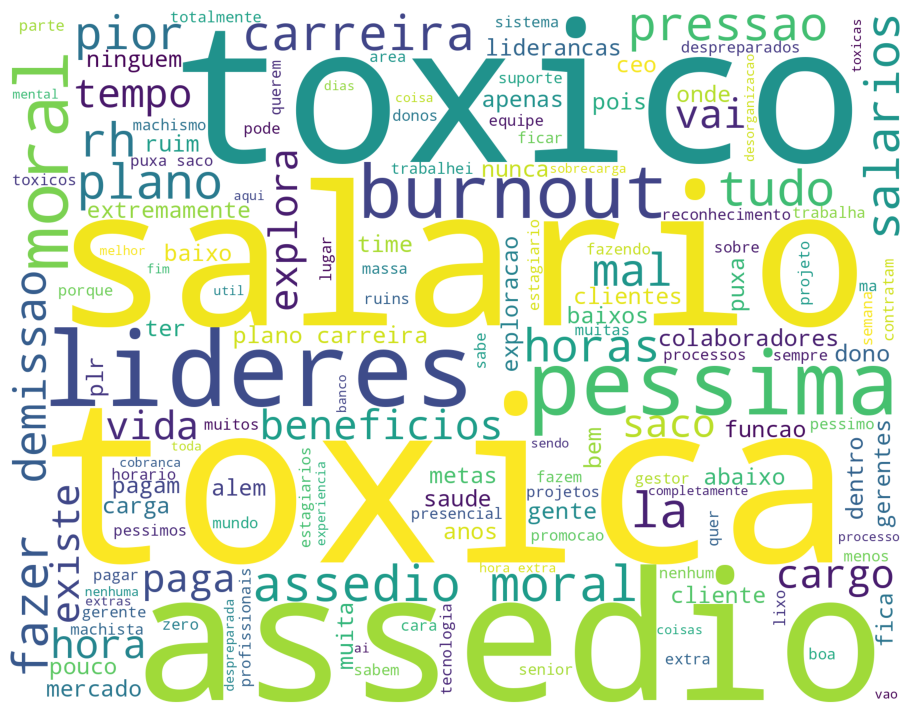

In [14]:
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

width = 18 // 1.5
height = 14 // 1.5
plt.figure(figsize=(width, height))
#text = 'all your base are belong to us all of your base base base'
wordcloud = WordCloud(
    stopwords=stops,
    width=1800,
    height=1400,
    background_color="white",
    max_words=150,
).generate_from_frequencies(df_term_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wptw_wordcloud.png", bbox_inches='tight', pad_inches=0.5)
plt.show()